I am really enjoying having this weather station.  I say weather
station, but it is just a raspberry pi with a pressure and temperature
sensor attached to it.
Computers are versatile, you can run any software on them, so they can
do a lot of different things.

But the pi takes this to a whole different level.  They are $40 or so,
depending on taxes and stuff.  Now you need a whole bunch of other
stuff: leads, keyboards, sensors, cameras, touch screens and lots more.

I have been using [Adafruit]().  They have been very helpful with orders.

I found browsing for parts and finding what I needed to get started
with the weather stuff a bit confusing for a while.

I had other stuff to do anyway, I needed to get used to just
installing software on them and setting up environments where I can
figure out how things are working.

I found a great [posting]() about building a weather station, with
enough detail I thought I would be able to work through it.

I order a cheap humidity sensor ($5) that also should do temperature.
I haven't got it working yet, not sure if it is hardware or software.
Meanwhile, I now have a better sensor.  The humidity here is often
outside the range the cheaper sensor is supposed to work.

The good thing is that I should be able to find a use for it at some point.

I also have a camera for this thing and a touchscreen.  I am thinking
of trying to combine them to make a camera.

The one on my phone can do some neat stuff, but the interface keeps
changing and not in ways that are making things easier.

The night skies have been spectacular of late, with Venus and Jupiter
close together in the early evening sky to the west.  If you see two
bright stars after sunset, that is probably them.

Then the moon is just past full.  Here in Bermuda there is often
cloud, not heavy, but patchy clouds.  The humidity is often very high,
so the atmosphere is interesting.

The best sunsets usually have some clouds for the setting sun to
reflect off.  The same with sunrises.

And the full moon too.  Tonight it rose behind cloud.  Last night it
was clearer and it rose orange/red.



### Back to weather
Since I got this thing working it has been hot and settled weather.
There is a strong Bermuda high in place.  Someone described it to me
as like a pit-bull, once it gets hold it does not let go.  So, we may
be in for a long hot spell.

With the pressure changing quite smoothly, the plots I created still
showed quite an interesting pattern.

Skip the next bit, or go back to the earlier [post](), it is just
setting things up to do some plotting.


In [37]:
# Tell matplotlib to plot in line
%matplotlib inline

# import pandas
import pandas

# seaborn magically adds a layer of goodness on top of Matplotlib
# mostly this is just changing matplotlib defaults, but it does also
# provide some higher level plotting methods.
import seaborn

# Tell seaborn to set things up
seaborn.set()



def smooth(data, thresh=None):
    
    means = data.mean()

    if thresh is None:
        sds = data.std()
    else:
        sds = thresh
    
    delta = data - data.shift()
    
    good = delta[abs(delta) < sds]

    print(good.describe())
    
    return delta.where(good, 0.0)

In [38]:
# set the path to the file we are going to analyse
infile = "../files/light.csv"

!scp 192.168.0.133:Adafruit_Python_BMP/light.csv ../files

light.csv                                     100% 1152KB   1.1MB/s   00:00    


In [39]:

""" assume it is csv and let pandas do magic

  index_col tells it to use the 'date' column in the data
  as the row index, plotting picks up on this and uses the
  date on the x-axis

  The *parse_dates* bit just tells it to try and figure out
  the date/time in the columne labeled 'date'.
"""
data = pandas.read_csv(infile, index_col='date', parse_dates=['date'])

               temp     pressure      altitude  sealevel_pressure
count  17182.000000  9107.000000  16958.000000        9071.000000
mean       0.000012     0.035357     -0.001912          -0.010363
std        0.033202     2.455906      0.518018           2.454953
min       -0.100000    -4.000000     -2.154588          -4.000000
25%        0.000000    -2.000000     -0.331733          -2.000000
50%        0.000000     0.000000      0.000000           0.000000
75%        0.000000     2.000000      0.331712           2.000000
max        0.100000     4.000000      2.240047           4.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ed0029390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2ecbfc4dd8>], dtype=object)

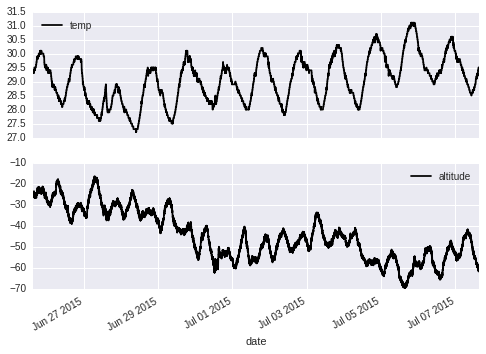

In [40]:
# incantation to extract the first record in the data
start = data[['temp', 'altitude']].irow(0)

# smooth the data to filter out bad temps and pressures
sdata = (smooth(data, 5.0).cumsum() + start)

# now use smooth to throw away dodgy data, and plot the temp and altitude fieldsa
sdata[['temp', 'altitude']].plot(subplots=True)

### Temperature
The temperature plot shows a steady up and down, warming during the
days, cooling a little, but only 2C at night.

There is one day, where I think we had some thunder storms where it dropped during the day.

The last week or so the temperature has been steadily climbing.

### Pressure

The Pressure also shows slow drifting up and down.  But there is this
other strange ripple up and down.

I mentioned this to a meteorologist and immediately got the reply that
it was because the atmosphere is tidal.

So the pattern we see in the pressure should be driven largely by the moon.



In [41]:
import astropy

In [42]:
from astropy import units
from astropy import find_api_page



In [43]:
# find_api_page is handy, even opens a browser windo.

#find_api_page(units)

In [44]:
# astropy is cool, but I need data for the moon.  Let's try pyephem

# uncommented the line below and run this cell if you need to install using
# pip.  This will install into the environment that is being used to run your
# ipython notebook server.

#!pip install pyephem

In [45]:
import ephem

In [46]:
# Create a Moon

moon = ephem.Moon()

In [47]:
# Tell it to figure out where it is
moon.compute()

# pring out the phase
moon.phase

63.725486755371094

In [48]:
def moon_orbitals(index):
    """ Given an index of times create a DataFrame of moon orbitals
    
    For now, just Phase, geocentric latitude and geocentric longitude
    """
    
    # Create dataframe with index as the index
    df = pandas.DataFrame(index=index)
    
    # Add three series
    df['phase'] = pandas.Series()
    df['glat'] = pandas.Series()
    df['glon'] = pandas.Series()
    
    # Now generate the data
    # NB this is slow, solpy might work out faster
    moon = ephem.Moon()
    for ix, timestamp in enumerate(index):
        
        # Compute the moon posigion
        moon.compute(timestamp.strftime("%Y/%m/%d %H:%M:%S"))
        
        df.phase[ix] = moon.phase
        df.glat[ix] = moon.hlat
        df.glon[ix] = moon.hlon
        
    return df
        
        

In [49]:
# See what we got

moon = moon_orbitals(data.index)
moon.describe()

,phase,glat,glon
count,17275.000000,17275.000000,17275.000000
mean,86.272549,0.060133,4.803310
std,11.509878,0.023218,0.827832
min,61.175819,0.007707,3.430130
25%,76.876801,0.041208,4.075469
50%,88.944550,0.065410,4.775424
75%,96.979935,0.081736,5.520241
max,99.811104,0.087505,6.273126


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ecb7233c8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2ecb67c208>], dtype=object)

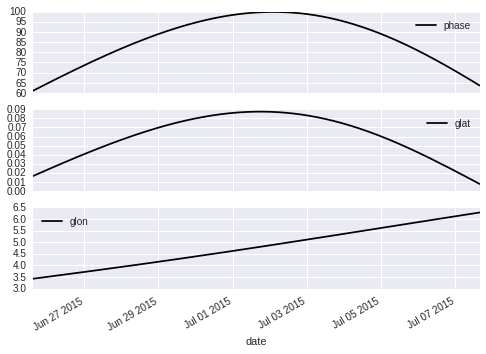

In [50]:
moon.plot(subplots=True)

In [51]:
# Try feeding in a longer time series
days = pandas.date_range('7/7/2015', periods=560, freq='D')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ecb570780>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2ecb4fe908>], dtype=object)

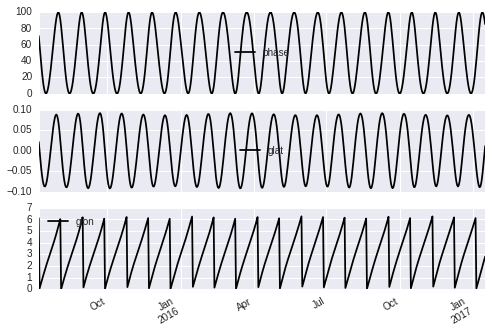

In [52]:
moon_orbitals(days).plot(subplots=True)

In [53]:
sdata['moon_phase'] = moon.phase
sdata['moon_glat'] = moon.glat
sdata['moon_glon'] = moon.glon

# FIXME -- must be a pandas one liner eg data += moon ?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ecb2ff898>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2ecb216908>], dtype=object)

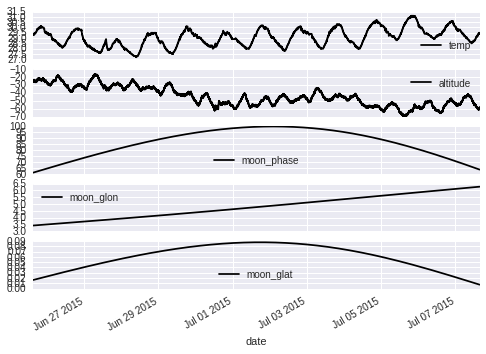

In [54]:
sdata[['temp', 'altitude', 'moon_phase', 'moon_glon', 'moon_glat']].plot(subplots=True)

### To be continued

For now, it is interesting to see that the latitude is almost in phase with the phase.  

Next job is to add these series to our data frame and then take a look at scikit-learn

In [55]:
print(sdata.index[0])
sdata.index[0].hour + (sdata.index[0].minute / 60.)

2015-06-25 15:07:37.174400


15.116666666666667

In [56]:
sdata.describe()

,altitude,pressure,sealevel_pressure,temp,moon_phase,moon_glat,moon_glon
count,17275.000000,0,0,17275.000000,17275.000000,17275.000000,17275.000000
mean,-44.629615,NaN,NaN,29.072747,86.272549,0.060133,4.803310
std,11.909578,NaN,NaN,0.820013,11.509878,0.023218,0.827832
min,-69.792586,NaN,NaN,27.200000,61.175819,0.007707,3.430130
25%,-54.470321,NaN,NaN,28.400000,76.876801,0.041208,4.075469
50%,-45.847784,NaN,NaN,29.100000,88.944550,0.065410,4.775424
75%,-34.410542,NaN,NaN,29.700000,96.979935,0.081736,5.520241
max,-16.471391,NaN,NaN,31.100000,99.811104,0.087505,6.273126


In [57]:
def tide_proxy(df):
    # Create dataframe with index as the index
    series = pandas.Series(index=df.index)
    
    for ix, timestamp in enumerate(df.index):
        hour_min = timestamp.hour + (timestamp.minute / 60.)
	
        hour_min += df.moon_glat[ix]

        series[ix] = hour_min
        
    return series
        


count    17275.000000
mean        12.053828
std          6.924004
min          0.021828
25%          6.056038
50%         12.065632
75%         18.036911
max         24.070675
dtype: float64

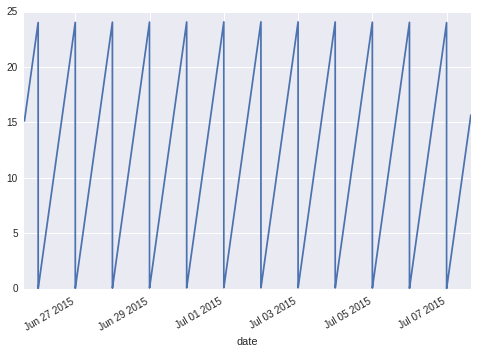

In [58]:
xx = tide_proxy(sdata)

xx.plot()

xx.describe()

In [59]:
In [11]:
# See what we got
moon = moon_orbitals(data.index)
moon.describe()
phase          glat          glon
count  17249.000000  17249.000000  17249.000000
mean      86.306382      0.060212      4.801097
std       11.485485      0.023146      0.826490
min       61.175819      0.008102      3.430130
25%       76.938377      0.041331      4.074461
50%       88.975983      0.065471      4.773237
75%       96.988121      0.081752      5.516829
max       99.811104      0.087505      6.268638



SyntaxError: invalid syntax (<ipython-input-59-1b5f36861285>, line 1)

In [60]:
sdata['tide'] = tide_proxy(sdata)

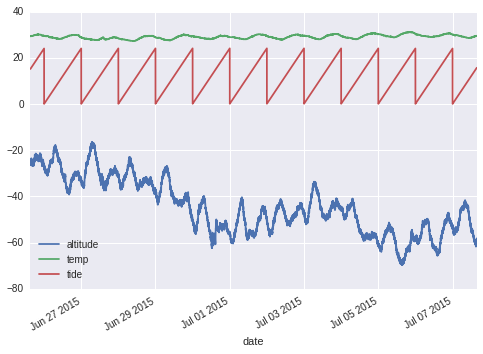

In [61]:
fields = ['altitude', 'temp', 'tide']

sdata[fields].plot()